###Задание 1. Подготовьте данные и обучите логистическую регрессию

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')

Mounted at /content/drive


В предыдущем занятии датасет был очищен, осталось только провести encoding категориальных переменных

In [ ]:
df = pd.read_excel(file_path).drop('Unnamed: 0', axis=1)
df.head()

,Result,stage,cost,patent,rd,eco,npv,pp,phd,foreigners,university,market,risks,own_res,unic,potential,fin_support,age,success,compet,investors,support,complexity,non_discl,city_Moscow,city_Spb
0,0,3,12.2,0,1,0,2.73,57,0.0,0,0,1,5,0.0,0,0.27,1,46,1,1,4,1,3,0,0,0
1,0,4,11.2,0,0,5,7.88,30,0.0,0,1,1,3,0.0,0,0.17,0,47,1,5,5,0,2,0,0,0
2,1,4,22.0,0,0,5,16.86,83,0.0,1,0,1,3,0.0,0,0.28,1,48,8,5,1,1,2,0,0,0
3,0,5,25.6,1,0,5,5.44,149,0.1,0,0,1,5,0.0,0,0.28,1,52,1,2,2,1,2,1,0,0
4,0,3,2.0,0,0,5,4.53,18,0.0,1,0,1,3,0.0,0,0.10,0,48,0,5,1,0,3,0,0,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Result,1458.0,0.2359,0.4247,0.00,0.000,0.00,0.0000,1.00
stage,1458.0,3.6283,1.3569,1.00,3.000,4.00,5.0000,5.00
cost,1458.0,11.1737,7.1489,0.40,5.700,10.00,15.3000,39.00
patent,1458.0,0.1200,0.3251,0.00,0.000,0.00,0.0000,1.00
rd,1458.0,0.2058,0.4044,0.00,0.000,0.00,0.0000,1.00
eco,1458.0,4.2833,2.5096,0.00,5.000,5.00,5.0000,10.00
npv,1458.0,7.8188,5.3641,0.22,3.565,6.80,10.7875,34.22
pp,1458.0,47.5576,27.8008,4.00,27.000,43.00,62.0000,149.00
phd,1458.0,0.1545,0.2475,0.00,0.000,0.00,0.2000,0.90
foreigners,1458.0,0.1269,0.3330,0.00,0.000,0.00,0.0000,1.00


Проведем one hot encoding категориальных переменных:
* Compet
* Complexity
* Eco
* Market
* Stage
* Age
* Risks

По столбцам Age и Risks предварительно сделаем биннинг переменных

In [ ]:
#в данном случае мне важно, какая переменная стала дефолтной (без соот. колонки), поэтому я написал свою функцию
#иначе лучше использовать pd.get_dummies
def one_hot_encode(df, columns, sep = '_', report = True):
  '''
  Returns a DataFrame where denoted columns are replaced with their one hot encoded variant. Does not tamper with original df
  '''
  output = df.loc[:, ~df.columns.isin(columns)]

  for column in columns:
    value_list = np.sort(df[column].unique())
    if report:
      print(f'OHE: for variable \'{column}\' value {value_list[0]} will be default condition (no corresponding column)')
    for value in value_list[1:]:
      output[f'{column}{sep}{value}'] = (df[column] == value).astype('int')
  return output

In [ ]:
df = one_hot_encode(df, ['compet', 'complexity', 'eco', 'market', 'stage'], sep = ' is ')
df

OHE: for variable 'compet' value 1 will be default condition (no corresponding column)
OHE: for variable 'complexity' value 1 will be default condition (no corresponding column)
OHE: for variable 'eco' value 0 will be default condition (no corresponding column)
OHE: for variable 'market' value 1 will be default condition (no corresponding column)
OHE: for variable 'stage' value 1 will be default condition (no corresponding column)


,Result,cost,patent,rd,npv,pp,phd,foreigners,university,risks,own_res,unic,potential,fin_support,age,success,investors,support,non_discl,city_Moscow,city_Spb,compet is 2,compet is 3,compet is 4,compet is 5,complexity is 2,complexity is 3,complexity is 4,eco is 5,eco is 10,market is 2,market is 3,market is 4,stage is 2,stage is 3,stage is 4,stage is 5
0,0,12.2,0,1,2.73,57,0.0,0,0,5,0.00,0,0.27,1,46,1,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,0,11.2,0,0,7.88,30,0.0,0,1,3,0.00,0,0.17,0,47,1,5,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
2,1,22.0,0,0,16.86,83,0.0,1,0,3,0.00,0,0.28,1,48,8,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0
3,0,25.6,1,0,5.44,149,0.1,0,0,5,0.00,0,0.28,1,52,1,2,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,0,2.0,0,0,4.53,18,0.0,1,0,3,0.00,0,0.10,0,48,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,0,14.5,0,0,2.34,98,0.7,0,0,5,0.00,0,0.20,0,45,3,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
1454,0,8.3,0,0,2.08,59,0.0,0,0,3,0.00,0,0.09,0,43,4,7,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1
1455,0,24.4,0,1,1.29,101,0.8,0,0,5,0.12,0,0.36,0,41,1,2,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0
1456,0,8.8,0,0,11.28,52,0.4,0,0,7,0.00,0,0.32,0,44,4,2,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0


In [ ]:
'''функция для более адекватного представления бинов
Если бы я делал ее заново, то принимал бы только одну серию и ее же возвращал,
а также ввел дополнительные проверки для интервалов (правый/левый и так далее)'''

def human_orient_qcut(df, columns, quantiles = 5):
  '''
  Returns a DataFrame where denoted columns are replaced with their bins in a more human-readable format
  '''
  output = df.loc[:, ~df.columns.isin(columns)]

  for column in columns:
    data, bins = pd.qcut(df[column], q=quantiles, retbins=True)
    bins.tolist()
    bins = list(map(int, bins))

    new_labels = [f'{bins[0]}-{bins[1]}']

    for i in range(1, len(bins)-1):
      if bins[i]+1 == bins[i+1]:
        new_labels.append(f'{bins[i]+1}')
      else:
        new_labels.append(f'{bins[i]+1}-{bins[i+1]}')
    output[column] = pd.qcut(df[column], quantiles, labels=new_labels)
  return output

In [ ]:
df = human_orient_qcut(df, ['age'], quantiles = 5)
df['age'].value_counts()

22-41    324
42-45    316
46-48    305
52-65    285
49-51    228
Name: age, dtype: int64

In [ ]:
df = human_orient_qcut(df, ['risks'], quantiles = 5)
df['risks'].value_counts()

1-3    568
4      270
7-9    246
5      212
6      162
Name: risks, dtype: int64

In [ ]:
df = one_hot_encode(df, ['age', 'risks'], sep = ' is ')
df

OHE: for variable 'age' value 22-41 will be default condition (no corresponding column)
OHE: for variable 'risks' value 1-3 will be default condition (no corresponding column)


,Result,cost,patent,rd,npv,pp,phd,foreigners,university,own_res,unic,potential,fin_support,success,investors,support,non_discl,city_Moscow,city_Spb,compet is 2,compet is 3,compet is 4,compet is 5,complexity is 2,complexity is 3,complexity is 4,eco is 5,eco is 10,market is 2,market is 3,market is 4,stage is 2,stage is 3,stage is 4,stage is 5,age is 42-45,age is 46-48,age is 49-51,age is 52-65,risks is 4,risks is 5,risks is 6,risks is 7-9
0,0,12.2,0,1,2.73,57,0.0,0,0,0.00,0,0.27,1,1,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,0,11.2,0,0,7.88,30,0.0,0,1,0.00,0,0.17,0,1,5,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,1,22.0,0,0,16.86,83,0.0,1,0,0.00,0,0.28,1,8,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0,25.6,1,0,5.44,149,0.1,0,0,0.00,0,0.28,1,1,2,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,0,2.0,0,0,4.53,18,0.0,1,0,0.00,0,0.10,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,0,14.5,0,0,2.34,98,0.7,0,0,0.00,0,0.20,0,3,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
1454,0,8.3,0,0,2.08,59,0.0,0,0,0.00,0,0.09,0,4,7,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1455,0,24.4,0,1,1.29,101,0.8,0,0,0.12,0,0.36,0,1,2,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1456,0,8.8,0,0,11.28,52,0.4,0,0,0.00,0,0.32,0,4,2,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1


In [ ]:
#переименовываем колонки под новую конвенцию
df = df.rename(columns={'city_Moscow' : 'city is Moscow', 'city_Spb' : 'city is Spb'})
df

,Result,cost,patent,rd,npv,pp,phd,foreigners,university,own_res,unic,potential,fin_support,success,investors,support,non_discl,city is Moscow,city is Spb,compet is 2,compet is 3,compet is 4,compet is 5,complexity is 2,complexity is 3,complexity is 4,eco is 5,eco is 10,market is 2,market is 3,market is 4,stage is 2,stage is 3,stage is 4,stage is 5,age is 42-45,age is 46-48,age is 49-51,age is 52-65,risks is 4,risks is 5,risks is 6,risks is 7-9
0,0,12.2,0,1,2.73,57,0.0,0,0,0.00,0,0.27,1,1,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
1,0,11.2,0,0,7.88,30,0.0,0,1,0.00,0,0.17,0,1,5,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,1,22.0,0,0,16.86,83,0.0,1,0,0.00,0,0.28,1,8,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0,25.6,1,0,5.44,149,0.1,0,0,0.00,0,0.28,1,1,2,1,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,0,2.0,0,0,4.53,18,0.0,1,0,0.00,0,0.10,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,0,14.5,0,0,2.34,98,0.7,0,0,0.00,0,0.20,0,3,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
1454,0,8.3,0,0,2.08,59,0.0,0,0,0.00,0,0.09,0,4,7,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1455,0,24.4,0,1,1.29,101,0.8,0,0,0.12,0,0.36,0,1,2,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1456,0,8.8,0,0,11.28,52,0.4,0,0,0.00,0,0.32,0,4,2,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Result,1458.0,0.2359,0.4247,0.00,0.000,0.00,0.0000,1.00
cost,1458.0,11.1737,7.1489,0.40,5.700,10.00,15.3000,39.00
patent,1458.0,0.1200,0.3251,0.00,0.000,0.00,0.0000,1.00
rd,1458.0,0.2058,0.4044,0.00,0.000,0.00,0.0000,1.00
npv,1458.0,7.8188,5.3641,0.22,3.565,6.80,10.7875,34.22
pp,1458.0,47.5576,27.8008,4.00,27.000,43.00,62.0000,149.00
phd,1458.0,0.1545,0.2475,0.00,0.000,0.00,0.2000,0.90
foreigners,1458.0,0.1269,0.3330,0.00,0.000,0.00,0.0000,1.00
university,1458.0,0.3169,0.4654,0.00,0.000,0.00,1.0000,1.00
own_res,1458.0,0.0347,0.1009,0.00,0.000,0.00,0.0000,0.75


Проведем стандартизацию номинальных показателей: cost, npv, pp, phd, own_res, potential, success, investors

In [ ]:
columns = ['cost', 'npv', 'pp', 'phd', 'own_res', 'potential', 'success', 'investors']
df[columns] = (df[columns]-df[columns].mean())/df[columns].std()

In [ ]:
pd.set_option("display.precision", 4)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Result,1458.0,2.3594e-01,0.4247,0.0000,0.0000,0.0000,0.0000,1.0000
cost,1458.0,-1.0600e-16,1.0000,-1.5070,-0.7657,-0.1642,0.5772,3.8924
patent,1458.0,1.2003e-01,0.3251,0.0000,0.0000,0.0000,0.0000,1.0000
rd,1458.0,2.0576e-01,0.4044,0.0000,0.0000,0.0000,0.0000,1.0000
npv,1458.0,-1.8519e-16,1.0000,-1.4166,-0.7930,-0.1899,0.5534,4.9219
pp,1458.0,-4.1424e-17,1.0000,-1.5668,-0.7395,-0.1639,0.5195,3.6489
phd,1458.0,6.8228e-17,1.0000,-0.6241,-0.6241,-0.6241,0.1840,3.0125
foreigners,1458.0,1.2689e-01,0.3330,0.0000,0.0000,0.0000,0.0000,1.0000
university,1458.0,3.1687e-01,0.4654,0.0000,0.0000,0.0000,1.0000,1.0000
own_res,1458.0,-4.6297e-17,1.0000,-0.3436,-0.3436,-0.3436,-0.3436,7.0884


In [ ]:
#разделим выборки на обучающую и тестовую
train, test = train_test_split(df, test_size=0.2)
y_train, x_train = train['Result'], train.drop('Result', axis=1)
y_test, x_test = test['Result'], test.drop('Result', axis=1)

In [ ]:
#обучим модель логистической регрессии
model = LogisticRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
#Вычислим основные метрики качества логистической модели: accuracy, precision, recall, f1-score, AUC
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       225
           1       0.77      0.76      0.77        67

    accuracy                           0.89       292
   macro avg       0.85      0.85      0.85       292
weighted avg       0.89      0.89      0.89       292



In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[210,  15],
       [ 16,  51]])

На тестовых данных точность равняется 88%, что является довольно
хорошим показателем для такой простой модели

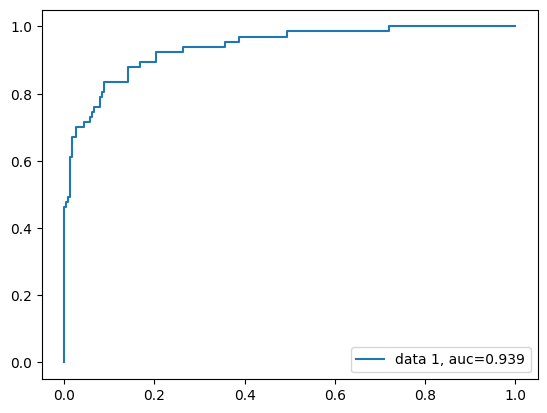

In [ ]:
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+f'{auc:.3f}')
plt.legend(loc=4)
plt.show()

In [ ]:
# Выведем коэффициенты модели для экономической интерпретации
columns = np.array('intercept', dtype='object')
columns = np.append(columns, x_train.columns.to_numpy())
coefs = model.intercept_.flatten()
coefs = np.append(coefs, model.coef_.flatten())

pd.DataFrame({'column' : columns, 'coef.' : coefs})

,column,coef.
0,intercept,-3.9183
1,cost,-0.0496
2,patent,-0.0414
3,rd,-0.7335
4,npv,0.4785
5,pp,-1.1582
6,phd,0.0154
7,foreigners,-0.1683
8,university,0.2312
9,own_res,0.2103


Экономическая интерпретация
1. Нефинансовая поддержка правительства увеличивает шансы на получение поддержки фонда
2. Экологичное решение сильно увеличивает шансы на получение поддержки фонда
3. Фонд предпочитает проекты с умеренным риском (4) проектам с низким риском (1-3, это значение по умолчанию, поэтому соот. коэффициента нет)
4. Сильная рискованность проекта (7-9) сильно уменьшает шансы на поддержку проекта фондом
5. Увеличение срока окупаемости проекта негативно влияет на его шансы получения поддержки фондом

###Задание 2. Уменьшите размерность модели, используя результаты первой модели, до 3 переменных или групп переменных

Для обучения следующей модели оставим три переменные (группы переменных): risks, eco, support, из-за того, что их эффект на предсказуваемую переменную в предыдущей модели максимален

In [ ]:
cols_model2 = ['risks is 4', 'risks is 5', 'risks is 6', 'risks is 7-9', 'eco is 5', 'eco is 10', 'support']

model = LogisticRegression().fit(x_train[cols_model2], y_train)
y_pred = model.predict(x_test[cols_model2])
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       225
           1       0.75      0.69      0.72        67

    accuracy                           0.88       292
   macro avg       0.83      0.81      0.82       292
weighted avg       0.87      0.88      0.87       292



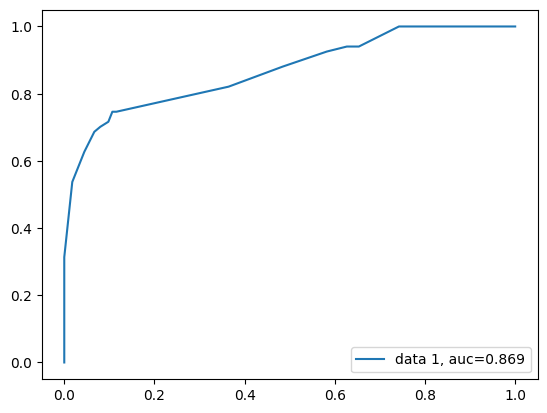

In [ ]:
y_pred_proba = model.predict_proba(x_test[cols_model2])[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+f'{auc:.3f}')
plt.legend(loc=4)
plt.show()

In [ ]:
columns = np.array('intercept', dtype='object')
columns = np.append(columns, x_train[cols_model2].columns.to_numpy())
coefs = model.intercept_.flatten()
coefs = np.append(coefs, model.coef_.flatten())

pd.DataFrame({'column' : columns, 'coef.' : coefs})

,column,coef.
0,intercept,-2.0925
1,risks is 4,-0.0006
2,risks is 5,-0.2560
3,risks is 6,-0.6944
4,risks is 7-9,-3.0762
5,eco is 5,0.5457
6,eco is 10,4.3534
7,support,1.9372


**Экономическая интерпретация**  
Результаты 1ой модели подтвердились, поэтому интерпретация совпадает
1. Нефинансовая поддержка правительства увеличивает шансы на получение поддержки фонда
2. Экологичное решение сильно увеличивает шансы на получение поддержки фонда
3. Сильная рискованность проекта (7-9) сильно уменьшает шансы на поддержку проекта фондом

**Выбор оптимальной модели**  
f-1 score первой модели равняется 0.88 (weighted average), второй модели - 0.85. ROC-AUC первой модели - 0.93, второй - 0.83.  
Так как качество первой модели выше, мы выбираем ее в качестве оптимальной
